This notebook is based a shortened version of my ***Clean Neural Network.ipynb*** notebook, adjusted to allow top-to-bottom running of the simple ANN section and to make it easier to understand and run, specifically for the simple ANN model. The latter has been left exactly as it is and can be used to attempt to make new tuners and improve the accuracy. The code has been copied from it as closely as possible and just some cells have been removed. This notebook is intended to allow adjusting of the number of height levels, number of atmospheric variables, number of epochs and the batch size but no further use of Keras-Tuner. For this notebook, KerasTuner will need to have been run in ***Clean Neural Network.ipynb***  and optimal hyperparameters found in order to load the tuner into this notebook and fit the optimal model.

❗❗❗ Note: make sure to increase the runtime to High-RAM 24Gb and use GPU for fast training of the model

## **Imports and Installing**

Install Keras Tuner - an automatic hyperparameter tuner - using pip

In [ ]:
!pip install -q -U keras-tuner

     |████████████████████████████████| 135 kB 5.2 MB/s 
     |████████████████████████████████| 1.6 MB 40.7 MB/s 


Import the necessary python libraries

In [ ]:
from netCDF4 import Dataset
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import os
import csv
from datetime import datetime
from mpl_toolkits import mplot3d
from mpl_toolkits.mplot3d import Axes3D
import pandas as pd
import PIL
import warnings
from csv import writer
from scipy import ndimage as nd
import random


from tensorflow import keras
from tensorflow.keras import layers
from keras.models import Model
from keras.layers import Dense
from keras.layers import Input
from keras.layers import concatenate
from keras.layers import Dropout
from keras.layers import Flatten
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D

⬛*Run the following cell only if keras tuner has been installed, to import it*

In [ ]:
import keras_tuner as kt

Set the seed for reproducibility

In [ ]:
random.seed(908)

## **Connect to Google Drive**

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=False)

Mounted at /content/gdrive


## **Compiling the Training Vectors**

⬛*Run the following section only if you want to reconstruct the variables on a new machine - otherwise just load in from the drive*

In [ ]:
def compile_variables():
      #store the file path for the list of all COGS files in chronological order
      file_list_csv = "/content/gdrive/MyDrive/Colab Notebooks/Data/processing_file_list_ignoring5files.csv"
      #use pandas to read in the file list csv file and iterate through them
      df = pd.read_csv(file_list_csv)
      cloud_perimeter = np.array([0.5,0.5])
      cloud_fraction = np.array([0.5,0.5])
      height = np.array([1,1])
      for row_index, filename in df.iterrows():
            filename_str=str(filename['File_names'])
            #specify the directories of the data files
            new_file_path_perimeter="/content/gdrive/MyDrive/Colab Notebooks/Data/Variables/Cloud Perimeter/"
            new_file_path_fraction="/content/gdrive/MyDrive/Colab Notebooks/Data/Variables/Cloud Fraction/"
            new_file_path_height="/content/gdrive/MyDrive/Colab Notebooks/Data/Variables/Height/"
            #specify the path to the next data file
            new_file_name_perimeter=new_file_path_perimeter+"Perimeter_"+filename_str[1:-5]+".csv"
            new_file_name_fraction=new_file_path_fraction+"Fraction_"+filename_str[1:-5]+".csv"
            new_file_name_height=new_file_path_height+"Height_"+filename_str[1:-5]+".csv"
            #read in the csv file
            perimeter_df = pd.read_csv(new_file_name_perimeter, header=None)
            # then convert to numpy array of floats
            perimeter_df = perimeter_df.to_numpy(dtype=np.float16)
            #repeat for the other two variables
            fraction_df = pd.read_csv(new_file_name_fraction, header=None)
            height_df = pd.read_csv(new_file_name_height, header=None)
            # then convert to numpy array of floats/integers
            fraction_df = fraction_df.to_numpy(dtype=np.float16)
            height_df = height_df.to_numpy(dtype='i')
            perimeter_df = perimeter_df.reshape(len(perimeter_df))
            fraction_df = fraction_df.reshape(len(fraction_df))
            height_df = height_df.reshape(len(height_df))
            cloud_fraction_mask = fraction_df > 0
            #mask the dataframe arrays with the cloud fraction mask
            perimeter_df=perimeter_df[cloud_fraction_mask]
            fraction_df=fraction_df[cloud_fraction_mask]
            height_df=height_df[cloud_fraction_mask]
            # concatenate the new vectors with the existing vectors
            cloud_perimeter = np.concatenate((cloud_perimeter,perimeter_df),axis=0)
            cloud_fraction = np.concatenate((cloud_fraction,fraction_df),axis=0)
            height = np.concatenate((height,height_df),axis=0)
            del perimeter_df
            del fraction_df
            del height_df


            #now work on the atmospheric data
            #specify the file path
            new_file_path_atmospheric = "/content/gdrive/MyDrive/Colab Notebooks/Data/Variables/Atmospheric/"
            new_file_name_atmospheric = new_file_path_atmospheric + "Atmospheric_"+filename_str[1:-5]+".npy"
            #load in the numpy array
            atmospheric_file = np.load(new_file_name_atmospheric)
            atmospheric_file = atmospheric_file[cloud_fraction_mask,:,:]
            variable_mask = [True,True,True,True,True,True,True,True,True,True]
            atmospheric_file = atmospheric_file[:,:,variable_mask]
            #if it's the first file set this to be the array itself
            if row_index == 0:
                  atmospheric_variables = atmospheric_file
            else:
                  atmospheric_variables = np.concatenate((atmospheric_variables,atmospheric_file),axis=0)
            del atmospheric_file
            print(row_index)

      cloud_perimeter = cloud_perimeter[2:]
      cloud_fraction = cloud_fraction[2:]
      height = height[2:]
      cloud_perimeter = cloud_perimeter.reshape(len(cloud_perimeter),1)
      cloud_fraction = cloud_fraction.reshape(len(cloud_fraction),1)
      height = height.reshape(len(height),1)
      return cloud_perimeter, cloud_fraction, height, atmospheric_variables

Construct the variables using the defined function and assert that the variables are of the correct shape. Also un-normalise the cloud perimeter variables in order to retain the dynamic range of the data

In [ ]:
#construct the variables
cloud_perimeter, cloud_fraction, height, atmospheric_variables = compile_variables()
#print the shapes of the variables
print(cloud_perimeter.shape)
print(cloud_fraction.shape)
print(height.shape)
#un-normalise cloud perimeter
cloud_perimeter = cloud_perimeter * 16200
#assert the shapes match
print(atmospheric_variables.shape)

Define a path to save the newly constructed variables

In [ ]:
new_file_directory = '/content/gdrive/MyDrive/Colab Notebooks/Data/Variables/Training Arrays/'

In [ ]:
#save the newly constructred variables
np.save(new_file_directory+'Perimeter',cloud_perimeter)
np.save(new_file_directory+'Height',height)
np.save(new_file_directory+'Fraction',cloud_fraction)
np.save(new_file_directory+'Atmospheric',atmospheric_variables)

Delete the variables to save RAM

In [ ]:
del atmospheric_variables
del cloud_perimeter
del height
del cloud_fraction

# **Method 4: Simple ANN with Keras Tuner**

## **Load in the Data**

Define the path to access the saved arrays

In [ ]:
new_file_directory = '/content/gdrive/MyDrive/Colab Notebooks/Data/Variables/Training Arrays/'

Load in the saved arrays into variables and assert the shapes are correct

In [ ]:
atmospheric_variables = np.load(new_file_directory+'Atmospheric.npy')
cloud_perimeter = np.load(new_file_directory+'Perimeter.npy')
height = np.load(new_file_directory+'Height.npy')
cloud_fraction = np.load(new_file_directory+'Fraction.npy')
print(cloud_perimeter.shape)
print(cloud_fraction.shape)
print(height.shape)
print(atmospheric_variables.shape)

(1767636, 1)
(1767636, 1)
(1767636, 1)
(1767636, 332, 10)


We do not require all atmospheric variables or height levels hence we create masks to reduce the array

In [ ]:
#take only the first 10 height levels
atmospheric_variables = atmospheric_variables[:,:7,:]
#take only 4 of the atmospheric variables
variable_mask = [True,False,False,True,True,True,False,True,True,False]
atmospheric_variables = atmospheric_variables[:,:,variable_mask]
#print the new shape of atmospheric variables
print(atmospheric_variables.shape)

(1767636, 10, 6)


Define the training, validation and test sets

In [ ]:
def train_val_test_split(atmospheric_variables,cloud_fraction,height,cloud_perimeter):
      random.seed(908)
      #check that the number of data points agree for all variables
      assert atmospheric_variables.shape[0]==cloud_fraction.shape[0] and \
      atmospheric_variables.shape[0]==height.shape[0] \
      and atmospheric_variables.shape[0]==cloud_perimeter.shape[0]

      num_data_points = int(atmospheric_variables.shape[0])
       
      #define the shuffling permutation and shuffle the variables in unison
      perm = np.random.permutation(num_data_points)
      atmospheric_variables = atmospheric_variables[perm,:,:]
      cloud_fraction = cloud_fraction[perm,:]
      height = height[perm,:]
      cloud_perimeter = cloud_perimeter[perm,:]

      #reshape the atmospheric variables to be a vector
      atmospheric_variables = np.reshape(atmospheric_variables,(atmospheric_variables.shape[0],-1))

      #combine the height, cloud fraction and atmospheric variables
      x=np.stack((cloud_fraction,height),axis=2)
      atmospheric_variables = np.reshape(atmospheric_variables,(atmospheric_variables.shape[0],1,atmospheric_variables.shape[1]))
      x=np.concatenate((x,atmospheric_variables),axis=2)

      #compute the training set size
      train_size=int(np.floor(0.7*num_data_points))
      val_size=int(np.floor(0.85*num_data_points))

      #specify the train, test and validation sets
      #split the data into train and test
      x_train=x[:train_size,:,:]
      y_train=cloud_perimeter[:train_size,:]
      #
      x_val=x[train_size:val_size,:,:]
      y_val=cloud_perimeter[train_size:val_size,:]
      #
      x_test=x[val_size:,:,:]
      y_test=cloud_perimeter[val_size:,:]

      return x_train, y_train, x_val, y_val, x_test, y_test

In [ ]:
x_train, y_train, x_val, y_val, x_test, y_test = train_val_test_split(atmospheric_variables,cloud_fraction,height,cloud_perimeter)
#find the parameters necessary
#check that x_train is a vector
assert x_train.shape[1]==1
print(x_train.shape[2])

62


Check the shape of x_test

In [ ]:
print(x_test.shape)

(265146, 1, 62)


Delete the variables to save RAM

In [ ]:
del atmospheric_variables
del cloud_fraction
del height
del cloud_perimeter

In [ ]:
directory = new_file_directory = '/content/gdrive/MyDrive/Colab Notebooks/Data/Train, Test, Val/ANN (rounding fixed)/'
np.save(directory+'x_train',x_train)
np.save(directory+'y_train',y_train)
np.save(directory+'x_val',x_val)
np.save(directory+'y_val',y_val)
np.save(directory+'x_test',x_test)
np.save(directory+'y_test',y_test)

## **Reload a saved tuner**

**hp function for the RoundingFixed_Hyperband_Tuner_simpleANN_allfiles**

❗❗❗ Uses the adaptive learning rate!

In [ ]:
def construct_model(hp):
      hp_units_z1 = hp.Int('units_1', min_value=32, max_value=512, step=32)
      hp_units_z2 = hp.Int('units_2', min_value=32, max_value=512, step=32)
      hp_units_z3 = hp.Int('units_3', min_value=16, max_value=256, step=16)
      hp_units_z4 = hp.Int('units_4', min_value=16, max_value=128, step=16)
      hp_dropout = hp.Choice('dropout', values = [0.0,0.1,0.2,0.3,0.4,0.5,0.6,0.7])
      #define the two inputs for the two heads of the network
      single_input=Input(shape=(1,44))
      z=Flatten()(single_input)
      z=Dense(units=hp_units_z1, activation="relu")(z)
      z=Dropout(hp_dropout)(z)
      z=Dense(units=hp_units_z2, activation="relu")(z)
      z=Dropout(hp_dropout)(z)
      z=Dense(units=hp_units_z3, activation="relu")(z)
      z=Dropout(hp_dropout)(z)
      z=Dense(units=hp_units_z4, activation="relu")(z)
      z=Dropout(hp_dropout)(z)
      z=Dense(1)(z)

      #finally define the outputs
      model=Model(inputs=single_input, outputs=z)

      opt_choice=keras.optimizers.Adam(learning_rate=0.01)
      model.compile(optimizer=opt_choice,loss="mse",metrics=['mae'])

      return model

In [ ]:
tuner = kt.Hyperband(construct_model,
                     objective='val_mae',
                     max_epochs=200,
                     directory='/content/gdrive/MyDrive/Colab Notebooks/Tuning',
                     project_name='RoundingFixed_Hyperband_Tuner_simpleANN_allfiles')

tuner.reload()

**hp function for the Hyperband_Tuner_simpleANN_allfiles**

❗❗❗ Uses the adaptive learning rate!

In [ ]:
def construct_model(hp):
      hp_units_z1 = hp.Int('units_1', min_value=32, max_value=512, step=32)
      hp_units_z2 = hp.Int('units_2', min_value=32, max_value=512, step=32)
      hp_units_z3 = hp.Int('units_3', min_value=16, max_value=256, step=16)
      hp_units_z4 = hp.Int('units_4', min_value=16, max_value=128, step=16)
      hp_dropout = hp.Choice('dropout', values = [0.0,0.1,0.2,0.3,0.4,0.5,0.6,0.7])
      #define the two inputs for the two heads of the network
      single_input=Input(shape=(1,44))
      z=Flatten()(single_input)
      z=Dense(units=hp_units_z1, activation="relu")(z)
      z=Dropout(hp_dropout)(z)
      z=Dense(units=hp_units_z2, activation="relu")(z)
      z=Dropout(hp_dropout)(z)
      z=Dense(units=hp_units_z3, activation="relu")(z)
      z=Dropout(hp_dropout)(z)
      z=Dense(units=hp_units_z4, activation="relu")(z)
      z=Dropout(hp_dropout)(z)
      z=Dense(1)(z)

      #finally define the outputs
      model=Model(inputs=single_input, outputs=z)

      opt_choice=keras.optimizers.Adam(learning_rate=0.01)
      model.compile(optimizer=opt_choice,loss="mse",metrics=['mae'])

      return model

In [ ]:
tuner = kt.Hyperband(construct_model,
                     objective='val_mae',
                     max_epochs=200,
                     directory='/content/gdrive/MyDrive/Colab Notebooks/Tuning',
                     project_name='Hyperband_Tuner_simpleANN_allfiles')

tuner.reload()

In [ ]:
best_hps=tuner.get_best_hyperparameters(num_trials=1)[0]

In [ ]:
model = tuner.hypermodel.build(best_hps)

In [ ]:
model.summary()

Model: "model_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_13 (InputLayer)       [(None, 1, 62)]           0         
                                                                 
 flatten_12 (Flatten)        (None, 62)                0         
                                                                 
 dense_60 (Dense)            (None, 192)               12096     
                                                                 
 dropout_48 (Dropout)        (None, 192)               0         
                                                                 
 dense_61 (Dense)            (None, 480)               92640     
                                                                 
 dropout_49 (Dropout)        (None, 480)               0         
                                                                 
 dense_62 (Dense)            (None, 96)                461

In [ ]:
adaptive_learning = True

In [ ]:
if adaptive_learning:
      def adapt_learning_rate(epoch):
              power = epoch // 20
              multiplier = 0.1 ** power
              if epoch < 60: 
                lr = 0.002 * multiplier
              else:
                lr = 2e-5
              return lr
      my_lr_scheduler = keras.callbacks.LearningRateScheduler(adapt_learning_rate)

In [ ]:
if adaptive_learning:
      history = model.fit(x=x_train, y=y_train, validation_data=(x_val, y_val), epochs=200, batch_size=2048, shuffle=True, callbacks=[my_lr_scheduler])
else:
      history = model.fit(x=x_train, y=y_train, validation_data=(x_val, y_val), epochs=200, batch_size=2048, shuffle=True)


Epoch 1/200
605/605 [==============================] - 3s 4ms/step - loss: 235566.5312 - mae: 312.7449 - val_loss: 77815.4531 - val_mae: 209.3579 - lr: 0.0020
Epoch 2/200
605/605 [==============================] - 2s 4ms/step - loss: 57483.9922 - mae: 136.2828 - val_loss: 61400.0938 - val_mae: 166.7823 - lr: 0.0020
Epoch 3/200
605/605 [==============================] - 2s 4ms/step - loss: 60927.3750 - mae: 145.1462 - val_loss: 50604.8203 - val_mae: 122.2027 - lr: 0.0020
Epoch 4/200
605/605 [==============================] - 2s 4ms/step - loss: 50875.9336 - mae: 123.6090 - val_loss: 50714.8203 - val_mae: 127.8996 - lr: 0.0020
Epoch 5/200
605/605 [==============================] - 2s 4ms/step - loss: 51440.0273 - mae: 128.6601 - val_loss: 49581.1602 - val_mae: 126.3613 - lr: 0.0020
Epoch 6/200
605/605 [==============================] - 2s 4ms/step - loss: 50424.5430 - mae: 126.9239 - val_loss: 50452.3164 - val_mae: 126.9041 - lr: 0.0020
Epoch 7/200
605/605 [==============================

# **Analysing the Model** 
#### Produced by either of the two methods

Output the hyperparameters found by the tuner

In [ ]:
tuner.results_summary()

Results summary
Results in /content/gdrive/MyDrive/Colab Notebooks/Tuning/RoundingFixed_Hyperband_Tuner_simpleANN_allfiles
Showing 10 best trials
Trial summary
Hyperparameters:
units_1: 192
units_2: 480
units_3: 96
units_4: 48
dropout: 0.0
tuner/epochs: 200
tuner/initial_epoch: 0
tuner/bracket: 0
tuner/round: 0
Score: 107.3078842163086
Trial summary
Hyperparameters:
units_1: 448
units_2: 288
units_3: 128
units_4: 96
dropout: 0.0
tuner/epochs: 23
tuner/initial_epoch: 0
tuner/bracket: 2
tuner/round: 0
Score: 107.56929016113281
Trial summary
Hyperparameters:
units_1: 192
units_2: 512
units_3: 192
units_4: 80
dropout: 0.1
tuner/epochs: 23
tuner/initial_epoch: 0
tuner/bracket: 2
tuner/round: 0
Score: 108.54713439941406
Trial summary
Hyperparameters:
units_1: 224
units_2: 128
units_3: 128
units_4: 80
dropout: 0.0
tuner/epochs: 67
tuner/initial_epoch: 0
tuner/bracket: 1
tuner/round: 0
Score: 109.04032135009766
Trial summary
Hyperparameters:
units_1: 480
units_2: 384
units_3: 112
units_4: 128


⬛Run this cell if you wish to save the model

❗❗❗ Note: adjust the file path to save as necessary to avoid overwriting the models

In [ ]:
model.save('/content/gdrive/MyDrive/Colab Notebooks/Models/RoundingFixedSimpleANNTunerModel16A7H2048BS500E')

Find the best epoch (in case we wish to do early stopping)

In [ ]:
val_acc_per_epoch = history.history['val_mae']
best_epoch = val_acc_per_epoch.index(min(val_acc_per_epoch)) + 1
print('Best epoch: %d' % (best_epoch,))

Best epoch: 490


Print a summary diagram of the model

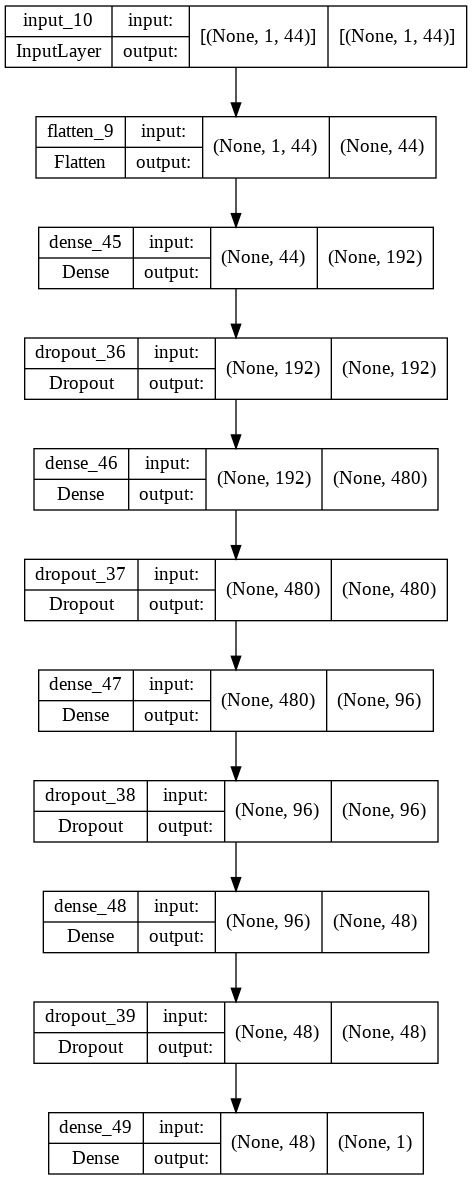

In [ ]:
keras.utils.plot_model(model, "single-headed CNN.png", show_shapes=True)

Print the test accuracy we have achieved

In [ ]:
test_loss, test_acc = model.evaluate(x_test, y_test, batch_size=128)
print(f"Test accuracy: {test_acc:.3f}")
print(f"Test loss: {test_loss:.3f}")

2072/2072 [==============================] - 4s 2ms/step - loss: 36023.9609 - mae: 99.3434
Test accuracy: 99.343
Test loss: 36023.961


Print the validation accuracy we have achieved

In [ ]:
val_loss, val_acc = model.evaluate(x_val, y_val, batch_size=2048)
print(f"Val accuracy: {val_acc:.3f}")
print(f"Val loss: {val_loss:.3f}")

130/130 [==============================] - 0s 2ms/step - loss: 38454.4766 - mae: 101.2780
Val accuracy: 101.278
Val loss: 38454.477


Use the model to make predictions on the test data and explicitly store these in a predictions variable

In [ ]:
predictions=model.predict([x1_test,x2_test])
print(predictions.shape)
print(y_test.shape)

(265146, 1)
(265146, 1)


Plot the predictions and the true labels on the same histogram to compare the model's predictions to the ground truth data

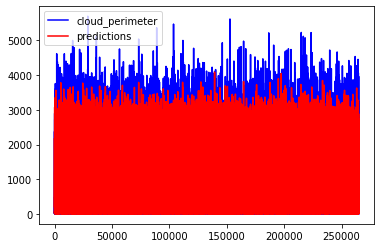

In [ ]:
x_range=range(len(predictions))
predictions=tf.squeeze(predictions)
y_test=tf.squeeze(y_test)
plt.plot(x_range,y_test,color='blue',label='cloud_perimeter')
plt.plot(x_range,predictions,color='red',label='predictions')
plt.legend()
plt.show()

Assert that the removal of all data points with a zero cloud fraction has removed all data points with a zero cloud perimeter (this is a sanity check which checks that the data has been cleaned correctly)

In [ ]:
zero_perimeters = y_test[y_test==0]
print(len(zero_perimeters)/len(y_test))

0.0


Plot a histogram of the predictions

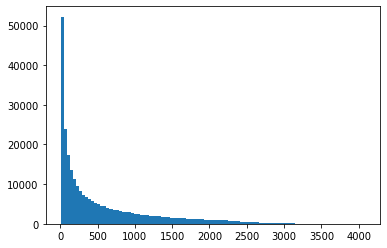

In [ ]:
plt.hist(predictions,bins=100)
plt.show()

Plot the equivalent histogram for the true labels

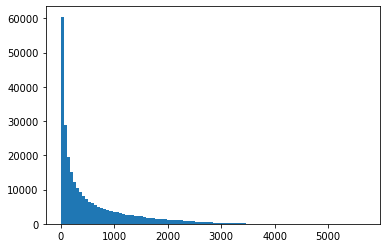

In [ ]:
plt.hist(y_test,bins=100)
plt.show()

Compute the mean average percentage error using the mae of the model

In [ ]:
test_acc/np.mean(y_test)

0.18326764083238822

Find the equivalent mean average percentage error of a naive prediction which just predicts the mean perimeter on the training data for every single test data point

In [ ]:
print(np.mean(np.absolute(y_test - np.mean(y_train)))/np.mean(y_test))

0.9290195120635726


Plot a graph of the train and validation error through the training process (ignoring the initial 2 epochs as these skew the graph)

<function matplotlib.pyplot.show(*args, **kw)>

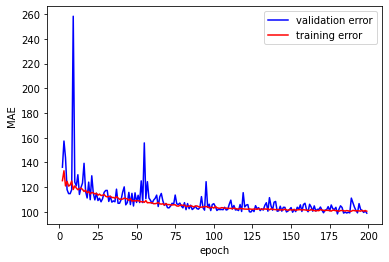

In [ ]:
x=range(200)
plt.plot(x[2:],history.history['val_mae'][2:],color = 'blue',label='validation error')
plt.plot(x[2:],history.history['mae'][2:],color = 'red',label='training error')
plt.legend()
plt.xlabel('epoch')
plt.ylabel('MAE')
plt.show

Plot a scatter graph of the predictions against the true labels to see if there is a good correlation

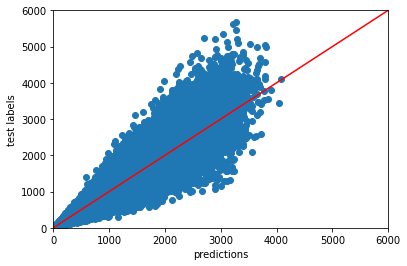

In [ ]:
x=range(6000)
plt.scatter(predictions,y_test)
plt.xlabel('predictions')
plt.ylabel('test labels')
plt.ylim((0,6000))
plt.xlim((0,6000))
plt.plot(x,x,color='red')
plt.show()

We now compare the predictions to a baseline detailed in *Improvements to a prognostic cloud scheme through changes to its cloud erosion parametrization* (Morcrette, 2012) which hypothesises a relationship of $P = \alpha F(1-F)$ where $P$ and $F$ are the perimeter and fraction respectively. The function below finds the optimal alpha from a search range and then computes the mean absolute percentage error using this prediction, for comparison with our model.

In [ ]:
def find_alpha(x2_train,y_train,y_test):
  #set the first mae to be the naive prediction of the mean for all points
  y_test=y_test/16200
  y_train=y_train/16200
  optimal_mae = np.mean(np.absolute(y_test - np.mean(y_train)))
  optimal_alpha = 0
  cloud_fraction = x2_train[:,:,0]
  y_train = y_train[:,0]
  mean_absolute_error_vector = []
  for step in range(100):
        alpha = step/100
        predicted_perimeter = []
        predicted_perimeter = np.multiply(cloud_fraction[:,0],(1-cloud_fraction[:,0]))
        predicted_perimeter = alpha*predicted_perimeter
        predicted_perimeter -= y_train
        predicted_perimeter = predicted_perimeter*(-1)
        mean_absolute_error = np.mean(np.absolute(predicted_perimeter))
        del predicted_perimeter
        mean_absolute_error_vector.append(mean_absolute_error)
        if mean_absolute_error < optimal_mae:
              optimal_mae = mean_absolute_error
              optimal_alpha = alpha
  mean_absolute_error_vector = np.array(mean_absolute_error_vector)
  x=range(100)
  plt.scatter(x,mean_absolute_error_vector)
  plt.show()

  return optimal_mae, optimal_alpha



In [ ]:
def compute_on_test_set(optimal_alpha,x2_test,y_test):
        y_test=y_test/16200
        #work out the error on the test set
        cloud_fraction = x2_test[:,:,0]
        test_predicted_perimeter = []
        y_test = y_test[:,0]
        for j in range(cloud_fraction.shape[0]):
              test_predicted_perimeter.append(optimal_alpha*cloud_fraction[j,0]*(1-cloud_fraction[j,0]))
        test_predicted_perimeter = np.array(test_predicted_perimeter)
        print(test_predicted_perimeter.shape)
        print(y_test.shape)
        final_mae = np.mean(np.absolute(y_test - test_predicted_perimeter))
        return final_mae


The percentage error is found to be 24%

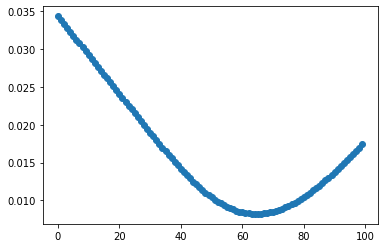

(265146,)
(265146,)
0.008241209252091075
0.64
Average percentage error = 0.23928261791950012


In [ ]:
optimal_mae, optimal_alpha = find_alpha(x2_train,y_train,y_test)
final_mae = compute_on_test_set(optimal_alpha,x2_test,y_test)
print(final_mae)
print(optimal_alpha)
print('Average percentage error =', final_mae/np.mean(y_test/16200))

We plot a graph of cloud fraction against normalised cloud perimeter and overlay the derived relationship over the top. It is clear that this is a good (essentially optimal) reflection of the relationship between cloud fraction and cloud perimeter. Therefore, our neural network must be finding more useful data in the height and atmospheric variables arrays with which to lower the error and make better predictions

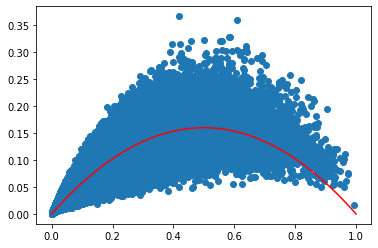

In [ ]:
x=np.linspace(0,1,100)
plt.scatter(x2_test[:,0,0],y_test/16200)
plt.plot(x,0.64*x*(1-x),color='red')
plt.show()